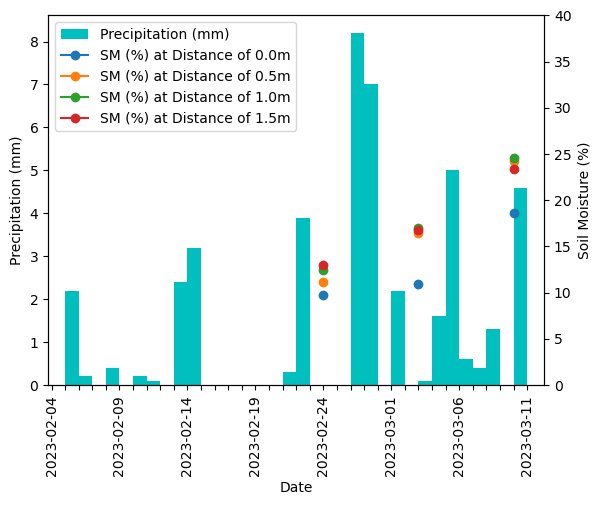

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt

#Range of x values
precip_strt = pd.to_datetime('2/4/2023 0:00')
precip_end = pd.to_datetime('3/12/2023 0:00')

#Read in data
sm_df = pd.read_csv('soil_moisture_digitized_data.csv')
lw_df = pd.read_csv('LW_15minSummary_2023_Preliminary.csv', header=19)

#Convert date from string to DateTime for consistent x-axis data type
sm_df['Date'] = pd.to_datetime(sm_df['Date'], format='%m/%d/%Y')
lw_df['DateTime'] = pd.to_datetime(lw_df['DateTime'], format='%m/%d/%Y %H:%M')

#--------------------------------------------------------------
# Precip plotting
#--------------------------------------------------------------
#Subset precip and get hourly precip from cumulative
precip_df = lw_df.loc[(lw_df['DateTime']>=precip_strt)&(lw_df['DateTime']<precip_end), ['DateTime', 'Precipitation-mm']]
precip_df['Precip-hrly-mm'] = precip_df['Precipitation-mm'].diff()
precip_df = precip_df.set_index('DateTime')
precip_df = precip_df.groupby(pd.Grouper(freq='1D')).sum().reset_index()
#Convert datetime to string so x values will be exactly the same as soil moisture (won't do both plot types otherwise)
precip_df['DateTime'] = precip_df['DateTime'].astype('string')
#Remove negative precips
precip_df['Precip-hrly-mm'] = precip_df['Precip-hrly-mm'].apply(lambda pr: 0 if pr < 0 else pr)
#Plot precip v time
ax = precip_df.plot(x='DateTime', y='Precip-hrly-mm', kind='bar', label='Precipitation (mm)',
                   ylabel='Precipitation (mm)', width = 1, align='edge', color='c')

#--------------------------------------------------------------
# Soil Moisture Plotting
#--------------------------------------------------------------
#Subset soil moisture df and find mean at each distance for each date
sm_sub_df = sm_df.loc[:, ['Date','Distance','Soil Moisture(%)']]
sm_mean_df = sm_sub_df.groupby(['Date', 'Distance']).mean()
sm_mean_df = sm_mean_df.reset_index()

#Plot SM v time for each distance (there probably a more elegant way, but this will work for now)
date_df = pd.DataFrame(pd.date_range(start=precip_strt, end=precip_end, inclusive='left'), columns=['Date'])    
for dist in [0.0, 0.5, 1.0, 1.5]:
    dist_df = sm_mean_df.loc[sm_mean_df['Distance'] == dist, ['Date', 'Soil Moisture(%)']]
    #We have to merge in all dates to match the histogram (histogram x-axis binning always uses integers as bin labels)
    dist_df = pd.merge(date_df, dist_df, how='left', on='Date')
    #Convert datetime to string so x values will be exactly the same as precip
    dist_df['Date'] = dist_df['Date'].astype('string')
    dist_df.plot(
        ax=ax, x='Date', y='Soil Moisture(%)', label='SM (%) at Distance of '+str(dist)+'m', secondary_y=True, 
        ylim=(0,40), ylabel='Soil Moisture (%)', marker = 'o', mark_right=False)
    
#Create list for x-tick values. Needs to be same length as histo data, but date should be listed every 5 days.
date_ls = date_df['Date'].astype('string').tolist()
date_inc = 5
for i in range(len(date_ls)):
    if i%date_inc != 0:
        date_ls[i] = None

ax.set_xticklabels(date_ls) 
ax.xaxis.set_tick_params(rotation=90)

plt.show()